In [2]:
from mvgavg import mvgavg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import glob
import skimage
import pandas as pd

path = "E:/Experimental_data/DREAM_microscope/"
exp = "2023-10-17_16_15_Activation_curve/"
list_output = glob.glob(path + exp + "*output*")

outputs = []
for i in list_output:
    outputs.append(pd.read_csv(i))



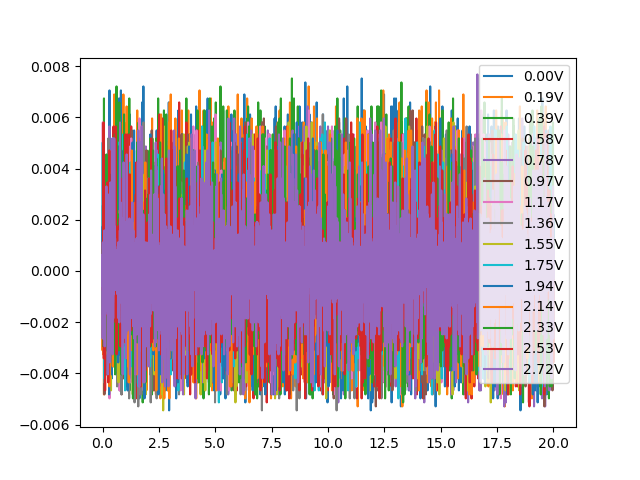

In [3]:
avg = 1
fig, ax = plt.subplots()
for i, output in enumerate(outputs):
    x = mvgavg(output["time"], avg)
    y = mvgavg(output["Fluo"], avg)
    ax.plot(x, y, label= list_output[i].split("\\")[-1].split("_")[-1].split(".csv")[0])

ax.legend()


In [4]:
list_output[i].split("\\")[-1].split("_")[-1].split(".csv")[0]

'2.72V'

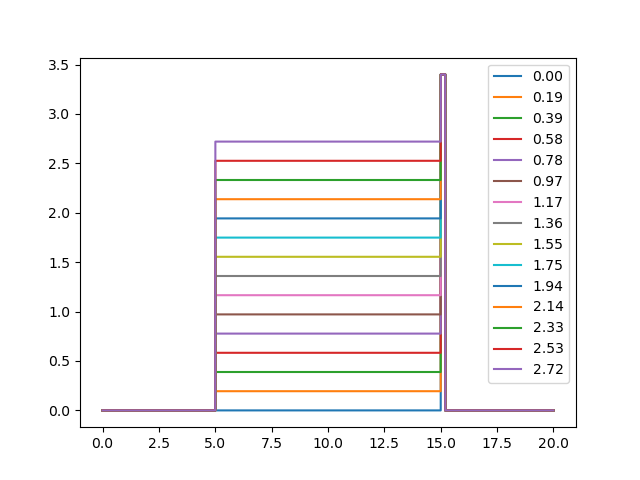

In [5]:
#LED
sat = 3.4 #V
duration_sat = 0.2 #ms 
start = 5
stop = 15

writing_rate =  1000 #Hz
acq_time = 20 #s
writing_samples = int(acq_time*writing_rate)

def fitness_sequence(offset, sat, start, stop, duration_sat):
    

    sample = np.linspace(0, acq_time, num = writing_samples , endpoint=False)
    actinic = np.zeros(sample.shape)
    actinic[start*writing_rate:stop*writing_rate] = offset
    pulse = np.zeros(sample.shape)
    pulse[stop*writing_rate:stop*writing_rate + int(duration_sat*writing_rate)] = sat

    signal = pulse + actinic

    return sample, signal

all_outputs = []
all_times = [] 
offsets = np.linspace(0, 0.8*sat, 15)

fig, ax = plt.subplots()

for i in offsets:
    sample, signal = fitness_sequence(i, sat, start, stop, duration_sat)
    all_outputs.append(signal)
    all_times.append(sample)

    ax.plot(sample, signal, label = f"{i:.2f}")
    ax.legend()







In [6]:
list_output = glob.glob(path + exp + "*video.tiff*")
list_time = glob.glob(path + exp + "*timing*")

data_dict = {}
intensity = []
for i in range(len(list_output)):
    video = skimage.io.imread(list_output[i])
    time_array = np.load(list_time[i])
    time = time_array-time_array[0]
    fluo = np.sum(video, axis = (1,2))
    if i == 0:
        data_dict["time"] = time
    data_dict[list_output[i].split("_")[-1].split("video")[0]] = fluo
    intensity.append(float(list_output[i].split("_")[-1].split("V")[0]))
    
data_df = pd.DataFrame(data_dict)

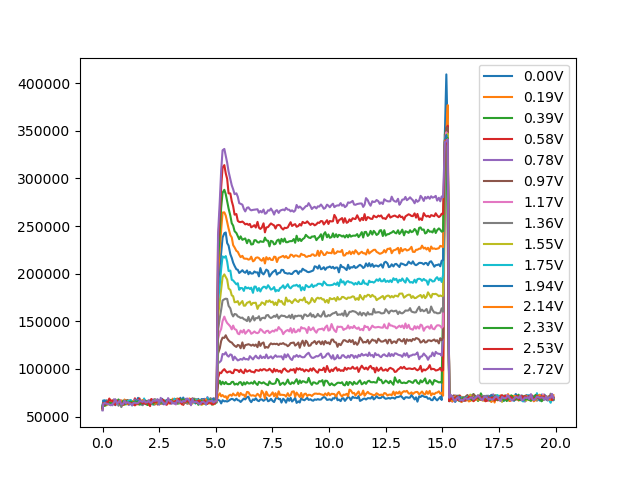

In [7]:
fig, ax = plt.subplots()
for i in data_df.columns:
    if i == "time":
        continue
    ax.plot(data_df["time"], data_df[i], label = i)
ax.legend()

In [12]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import tools

sys.path.append("C:/Users/Lab/Desktop/DREAM_repo/Codes_Alienor/PAMFluo-dynamic_python")
import tools
import importlib
import VoltageIntensityClass

importlib.reload(VoltageIntensityClass)

def compute_params(Data_df, I_volt, I_sat_volt):
    importlib.reload(VoltageIntensityClass)

    
    V = VoltageIntensityClass.VoltageIntensity(folder = "E:/Experimental_data/DREAM_microscope/2023-10-16_15_53_bode_diagram")
    I = V.get_intensity_voltage("blue", 1, I_volt)
    I_sat = V.get_intensity_voltage("blue", 1, I_sat_volt)


    
    F_max = []
    F_stat = []
    F_0 = []
    phi_stat = []
    phi_0 = []
    NPQ = []
    ETR = []

    for i, k in enumerate(Data_df.columns[1:]):
        F_max.append(np.max(Data_df[k]))
        NPQ.append((F_max[0] - F_max[i-1])/F_max[i])
        if I[i] == 0:
            F_stat.append(0)
            phi_stat.append(0)
            ETR.append(0)
            continue
        F_stat.append(np.mean(Data_df[k][tools.closest_index(Data_df.time, 10):tools.closest_index(Data_df.time, 14.9)]))
        phi_stat.append((F_max[i] - F_stat[i]) / F_max[i])
        ETR.append(phi_stat[i] * I[i])
       
    norm = F_max[0]
    
    F_max = list(np.array(F_max)/norm)
    F_stat = list(np.array(F_stat)/norm)
        
    params_df = pd.DataFrame({'Actinic': I, 'F_max': F_max, 'F_stat': F_stat, 'phi_stat': phi_stat, 'NPQ': NPQ, 'ETR': ETR})
    
    return params_df

In [14]:
params_df = compute_params(data_df, intensity, 3.4)
params_df


,Actinic,F_max,F_stat,phi_stat,NPQ,ETR
0,1.412393e-05,1.000000,0.169611,0.830389,0.000000,1.172836e-05
1,5.692542e-06,0.921254,0.181468,0.803021,0.000000,4.571231e-06
2,2.329961e-07,0.861705,0.210333,0.755911,0.091384,1.761243e-07
3,-1.909669e-06,0.868314,0.244278,0.718676,0.159269,-1.372433e-06
4,-1.171337e-06,0.857559,0.278838,0.674847,0.153559,-7.904730e-07
5,2.182205e-06,0.863963,0.315557,0.634756,0.164869,1.385167e-06
6,8.303221e-06,0.851510,0.351194,0.587563,0.159760,4.878665e-06
7,1.639662e-05,0.844377,0.389924,0.538211,0.175858,8.824849e-06
8,2.653605e-05,0.848063,0.429602,0.493432,0.183504,1.309372e-05
9,3.923627e-05,0.842566,0.468717,0.443703,0.180326,1.740926e-05


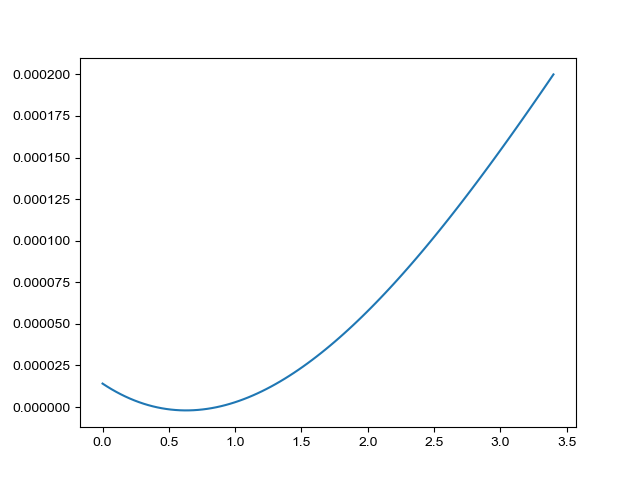

In [17]:
V = VoltageIntensityClass.VoltageIntensity(folder = "E:/Experimental_data/DREAM_microscope/2023-10-16_15_53_bode_diagram")

voltage = np.linspace(0, 3.4, 100)
intensity = V.get_intensity_voltage("blue", 1, voltage)

fig, ax = plt.subplots()
ax.plot(voltage, intensity)

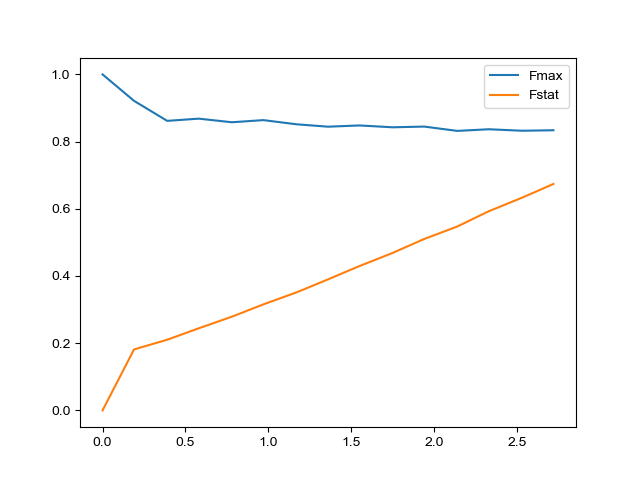

In [137]:
fig, ax = plt.subplots()
ax.plot(params_df.Actinic, params_df.F_max, label = "Fmax")
ax.plot(params_df.Actinic, params_df.F_stat, label = "Fstat")
ax.legend()

In [102]:
len(NPQ)

14